In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import tensorflow as tf
tf.random.set_seed(1234)

warnings.filterwarnings('ignore')

import os
def load_data():
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            if filename.endswith('.csv'):
                data = pd.read_csv(os.path.join(dirname, filename))
                return data

In [2]:
data = load_data()

In [3]:
# avoid OOM error by set the GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

# print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[]


In [10]:
# menampilkan dataset
data.head()

,sequence,length,class
0,AATAATTTGTGCACTTCAGAATATTCTACAATAATATATTATTTCC...,1010,DMT2
1,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1010,DMT2
2,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1013,DMT2
3,AGTTGGAGTCTCCAGGGATCAGGGTTCCAGGAACTCAGGATCTGCA...,1013,DMT2
4,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1015,DMT2


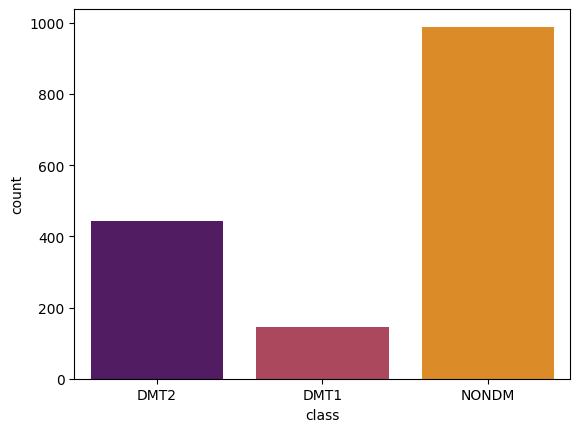

In [11]:
# check the datasize
sns.countplot(data, x='class', palette='inferno')
plt.show()

In [12]:
# ==================== PREPROCESSING ====================
# split into k-mers
# memecah sekuens dna menjadi mers
def kmers(seq, size):
    kmers = [seq[x:x+size].lower() for x in range(len(seq)-size+1)]
    return kmers

data['3mers'] = data.apply(lambda x: kmers(x['sequence'], size=3), axis=1)
data['4mers'] = data.apply(lambda x: kmers(x['sequence'], size=4), axis=1)
data['5mers'] = data.apply(lambda x: kmers(x['sequence'], size=5), axis=1)
data['6mers'] = data.apply(lambda x: kmers(x['sequence'], size=6), axis=1)

In [13]:
# split X, y data
X_3= list(data['3mers'])
X_3= [(' '.join(X_3[seq])) for seq in range(len(X_3))]
y = data['class'].copy()
print(f"3-mers: {X_3[3]}")
X=list(data['4mers'])

3-mers: agt gtt ttg tgg gga gag agt gtc tct ctc tcc cca cag agg ggg gga gat atc tca cag agg ggg ggt gtt ttc tcc cca cag agg gga gaa aac act ctc tca cag agg gga gat atc tct ctg tgc gca cag agt gtg tga gag agg gga gac acc cca cag aga gac aca cac acc cca cac act ctg tga gat att ttg tgc gca cag agg gga gaa aat atg tgt gtg tgt gtt ttc tcc ccc cct ctc tcc ccc ccc cca cat atg tgg ggc gca caa aag aga gat ata tac act cta tac aca cat ata taa aat att tta taa aaa aat ata tat atg tgc gca cag aga gac acc cca cag aga gaa aag agg ggc gct ctc tct cta tat ata tac aca cac aca caa aag aga gag aga gat atg tgg ggc gcc cca cag agc gct ctg tgc gct ctg tgg ggt gtg tgg ggg gga gag aga gat atc tcc cct ctg tgt gtt ttg tgc gca cag aga gac aca caa aac act ctg tgc gct ctg tgt gtg tgc gca cag aga gag aga gaa aag aga gat atc tct ctg tgc gca cat ata tac act ctt ttc tcc cct cta taa aac aca cag aga gag agg ggc gct ctt ttg tgg ggc gcc ccc ccg cgc gca cac acc cca caa aag agg ggt gtc tcc ccc ccc cca cat att ttt ttt ttc tcc 

In [14]:
# tokenize each kmer pairs
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_3)

X_tokenized = tokenizer.texts_to_sequences(X_3)

max_dna = max([len(s.split()) for s in X_3])
print('max DNA length {}'.format(max_dna))

X_padded = pad_sequences(X_tokenized, maxlen=max_dna, padding='post')
print({X_padded.shape[0]})

max DNA length 9203
{1577}


In [18]:
print(f"X-before tokenized: {X[5][:16]}")
print()
print(f"X-after tokenized: {X_tokenized[5][:16]}")
print()

X-before tokenized: ['tgtg', 'gtgc', 'tgca', 'gcac', 'cacg', 'acgc', 'cgca', 'gcac', 'cacc', 'accc', 'ccct', 'cctc', 'ctct', 'tctc', 'ctcc', 'tccc']

X-after tokenized: [18, 27, 22, 32, 37, 61, 59, 32, 37, 39, 11, 7, 21, 17, 21, 26]



In [ ]:
# import pandas as pd

# # Ubah list ke DataFrame
# X_tokenized = pd.DataFrame(X_tokenized)
# print("Ukuran data:", X_tokenized[1].shape)

In [19]:
# encode the classes
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

oh = LabelEncoder()

labels = np.array(y)
labels = oh.fit_transform(labels)

In [20]:
print(f"Class before encoded: \n{y[:20]}")
print()
print(f"Class after encoded: \n{labels[:20]}")

Class before encoded: 
0     DMT2
1     DMT2
2     DMT2
3     DMT2
4     DMT2
5     DMT2
6     DMT1
7     DMT2
8     DMT2
9     DMT2
10    DMT2
11    DMT1
12    DMT2
13    DMT2
14    DMT2
15    DMT1
16    DMT2
17    DMT2
18    DMT2
19    DMT2
Name: class, dtype: object

Class after encoded: 
[1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1]


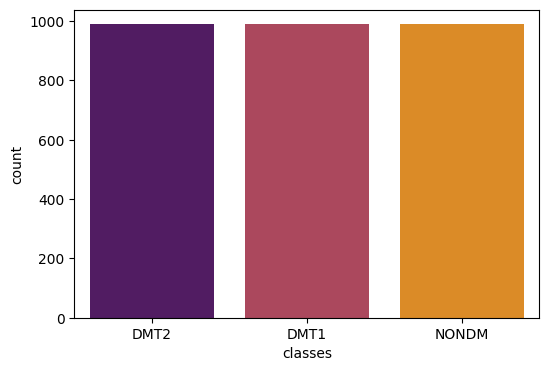

In [21]:
from imblearn.over_sampling import SMOTE

# Membuat objek SMOTE
smote = SMOTE(random_state=42)

# Lakukan oversampling pada data yang sudah bebas dari outlier
X_os, y_os = smote.fit_resample(X_padded, y)

# see the classes after oversampling
OSclasses = pd.DataFrame(y_os)
OSclasses.columns = ['classes']

plt.subplots(figsize=(6,4))
sns.countplot(OSclasses, x='classes', palette='inferno')
plt.show()

In [26]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.2, random_state=42, stratify=y_os)

In [27]:
print(f'X_train size is {X_train.shape}')
print(f'y_train size is {y_train.shape}')
print(f'X_test size is {X_test.shape}')
print(f'y_test size is {y_test.shape}')

X_train size is (2373, 9203)
y_train size is (2373,)
X_test size is (594, 9203)
y_test size is (594,)


In [28]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# ====================================
# Helper function to create k-mers
def kmers(seq, size):
    return [seq[x:x + size].lower() for x in range(len(seq) - size + 1)]
    
# Function to preprocess and train SVM with given parameters
def process_and_train_svm(data, k, kernels, C_values):
    # Split into k-mers
    data[f'{k}mers'] = data.apply(lambda x: kmers(x['sequence'], size=k), axis=1)

    # Prepare X and y
    X = list(data[f'{k}mers'])
    X = [(' '.join(X[seq])) for seq in range(len(X))]
    y = data['class'].copy()

    # Tokenize
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)
    X_tokenized = tokenizer.texts_to_sequences(X)
    max_dna = max([len(s.split()) for s in X])
    X_padded = pad_sequences(X_tokenized, maxlen=max_dna, padding='post')

    # Encode labels
    label_encoder = LabelEncoder()
    labels = np.array(y)
    labels = label_encoder.fit_transform(labels)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_os, y_os = smote.fit_resample(X_padded, labels)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.1, random_state=42, stratify=y_os)

    # Train SVM for each kernel and C value
    for kernel in kernels:
        print(f"\n================= Kernel: {kernel} =================")
        for C in C_values:
            svm = SVC(kernel=kernel, C=C)
            svm.fit(X_train, y_train)
            
            # Predict and evaluate
            y_pred = svm.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred)

            # Print results
            print(f'Kernel: {kernel}, C={C}')
            print(f'Accuracy: {accuracy:.2f}')
            print(f'Classification Report:\n{report}')
            print('-' * 60)

# ====================================
# Load your dataset here
# Assuming `data` DataFrame has columns 'sequence' and 'class'

# Parameter values
C_values = [0.01, 0.1, 1, 10, 100]
kernels = ['rbf', 'poly', 'sigmoid']

# Run the processing and training for 4-mers
print("Processing and training for 3-mers...")
process_and_train_svm(data, k=3, kernels=kernels, C_values=C_values)

# Run the processing and training for 4-mers
print("Processing and training for 4-mers...")
process_and_train_svm(data, k=4, kernels=kernels, C_values=C_values)

# Run the processing and training for 5-mers
print("\nProcessing and training for 5-mers...")
process_and_train_svm(data, k=5, kernels=kernels, C_values=C_values)

Processing and training for 3-mers...

================= Kernel: rbf =================
Kernel: rbf, C=0.01
Accuracy: 0.52
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.59      0.58        99
           1       1.00      0.07      0.13        99
           2       0.47      0.90      0.62        99

    accuracy                           0.52       297
   macro avg       0.68      0.52      0.44       297
weighted avg       0.68      0.52      0.44       297

------------------------------------------------------------
Kernel: rbf, C=0.1
Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        99
           1       0.81      0.42      0.56        99
           2       0.61      0.90      0.73        99

    accuracy                           0.68       297
   macro avg       0.71      0.68      0.66       297
weighted avg       0.71      0


Results for 4-mers, Kernel: rbf, C=10
Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        99
           1       0.99      0.89      0.94        99
           2       0.94      0.99      0.97        99

    accuracy                           0.96       297
   macro avg       0.96      0.96      0.96       297
weighted avg       0.96      0.96      0.96       297

Confusion Matrix:
[[99  0  0]
 [ 5 88  6]
 [ 0  1 98]]


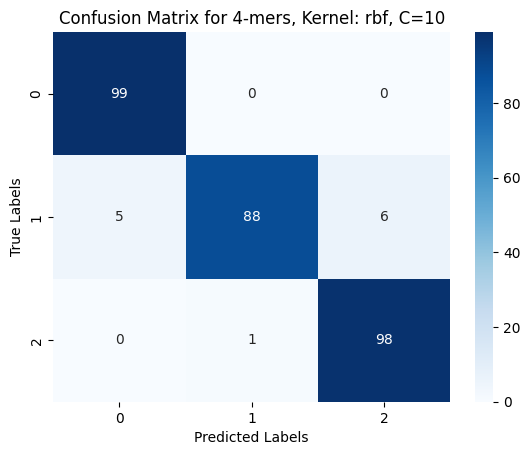

In [29]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# ====================================
# Helper function to create k-mers
def kmers(seq, size):
    return [seq[x:x + size].lower() for x in range(len(seq) - size + 1)]

# ====================================
# Function to preprocess and train SVM with specified parameters
def process_and_train_svm_specific(data, k=4, kernel='rbf', C=10):
    # Split into k-mers
    data[f'{k}mers'] = data.apply(lambda x: kmers(x['sequence'], size=k), axis=1)

    # Prepare X and y
    X = list(data[f'{k}mers'])
    X = [(' '.join(X[seq])) for seq in range(len(X))]
    y = data['class'].copy()

    # Tokenize
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)
    X_tokenized = tokenizer.texts_to_sequences(X)
    max_dna = max([len(s.split()) for s in X])
    X_padded = pad_sequences(X_tokenized, maxlen=max_dna, padding='post')

    # Encode labels
    label_encoder = LabelEncoder()
    labels = np.array(y)
    labels = label_encoder.fit_transform(labels)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_os, y_os = smote.fit_resample(X_padded, labels)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.1, random_state=42, stratify=y_os)

    # Train SVM with specified kernel and C
    svm = SVC(kernel=kernel, C=C)
    svm.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\nResults for {k}-mers, Kernel: {kernel}, C={C}")
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Classification Report:\n{report}')
    print(f'Confusion Matrix:\n{cm}')
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {k}-mers, Kernel: {kernel}, C={C}')
    plt.show()

# Run the specific SVM training for 4-mers with rbf kernel and C=10
process_and_train_svm_specific(data, k=4, kernel='rbf', C=10)


In [32]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE

# ====================================
# Helper function to create k-mers
def kmers(seq, size):
    return [seq[x:x + size].lower() for x in range(len(seq) - size + 1)]

# ====================================
# Function to preprocess, train, and evaluate SVM
def process_and_train_svm_comparison(data, k=4, kernel='rbf', C=10):
    # Split into k-mers
    data[f'{k}mers'] = data.apply(lambda x: kmers(x['sequence'], size=k), axis=1)

    # Prepare X and y
    X = list(data[f'{k}mers'])
    X = [(' '.join(X[seq])) for seq in range(len(X))]
    y = data['class'].copy()

    # Tokenize
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)
    X_tokenized = tokenizer.texts_to_sequences(X)
    max_dna = max([len(s.split()) for s in X])
    X_padded = pad_sequences(X_tokenized, maxlen=max_dna, padding='post')

    # Encode labels
    label_encoder = LabelEncoder()
    labels = np.array(y)
    labels = label_encoder.fit_transform(labels)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_os, y_os = smote.fit_resample(X_padded, labels)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.1, random_state=42, stratify=y_os)

    # Train SVM with specified kernel and C
    svm_model = SVC(kernel=kernel, C=C)
    svm_model.fit(X_train, y_train)

    # Predict on test data
    y_pred = svm_model.predict(X_test)

    # Create comparison DataFrame
    comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    comparison_df['Correct'] = comparison_df['Actual'] == comparison_df['Predicted']

    # Display comparison table
    print("\nComparison of Actual vs. Predicted:")
    print(comparison_df)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy with C={C}: {accuracy:.2f}")

    # Display incorrect predictions
    incorrect_predictions = comparison_df[comparison_df['Correct'] == False]
    print("\nIncorrect Predictions:")
    print(incorrect_predictions)

# Example usage
# Replace 'data' with your actual DataFrame containing 'sequence' and 'class' columns
process_and_train_svm_comparison(data, k=4, kernel='rbf', C=10)



Comparison of Actual vs. Predicted:
     Actual  Predicted  Correct
0         1          1     True
1         2          2     True
2         1          1     True
3         2          2     True
4         2          2     True
..      ...        ...      ...
292       0          0     True
293       1          1     True
294       1          1     True
295       0          0     True
296       2          2     True

[297 rows x 3 columns]

Accuracy with C=10: 0.96

Incorrect Predictions:
     Actual  Predicted  Correct
14        1          2    False
81        1          0    False
85        1          0    False
125       1          2    False
159       1          2    False
167       1          0    False
233       2          1    False
256       1          0    False
275       1          2    False
278       1          2    False
280       1          0    False
284       1          2    False



Results for Fold 1, 4-mers, Kernel: rbf, C=10
Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        99
           1       0.96      0.93      0.94        99
           2       0.97      0.99      0.98        99

    accuracy                           0.96       297
   macro avg       0.96      0.96      0.96       297
weighted avg       0.96      0.96      0.96       297

Confusion Matrix:
[[96  3  0]
 [ 4 92  3]
 [ 0  1 98]]


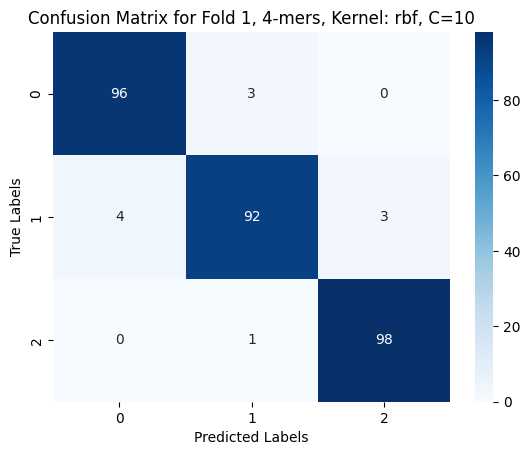


Results for Fold 2, 4-mers, Kernel: rbf, C=10
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        99
           1       0.94      0.88      0.91        99
           2       0.97      0.97      0.97        99

    accuracy                           0.94       297
   macro avg       0.94      0.94      0.94       297
weighted avg       0.94      0.94      0.94       297

Confusion Matrix:
[[96  3  0]
 [ 9 87  3]
 [ 0  3 96]]


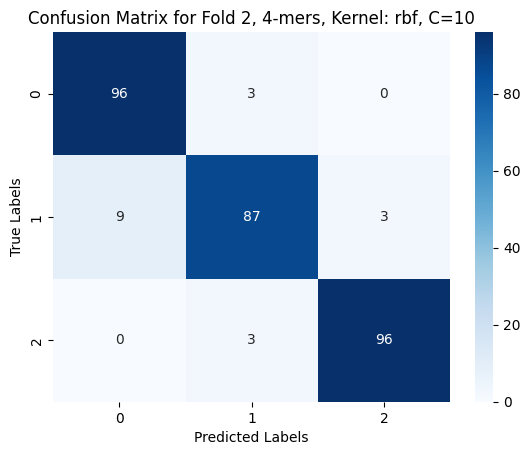


Results for Fold 3, 4-mers, Kernel: rbf, C=10
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        99
           1       0.96      0.86      0.90        99
           2       0.97      0.97      0.97        99

    accuracy                           0.94       297
   macro avg       0.94      0.94      0.94       297
weighted avg       0.94      0.94      0.94       297

Confusion Matrix:
[[98  1  0]
 [11 85  3]
 [ 0  3 96]]


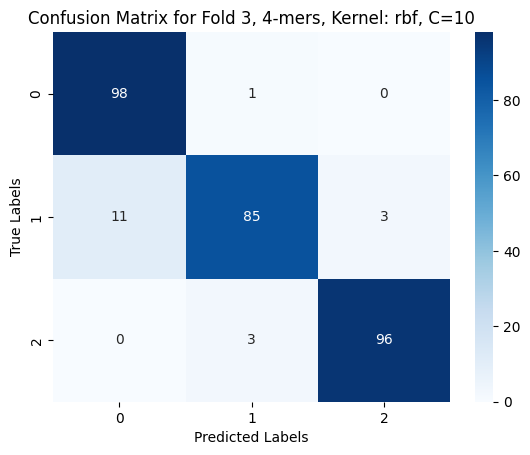


Results for Fold 4, 4-mers, Kernel: rbf, C=10
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        99
           1       0.94      0.80      0.86        99
           2       0.92      0.97      0.95        99

    accuracy                           0.92       297
   macro avg       0.92      0.92      0.91       297
weighted avg       0.92      0.92      0.91       297

Confusion Matrix:
[[97  2  0]
 [12 79  8]
 [ 0  3 96]]


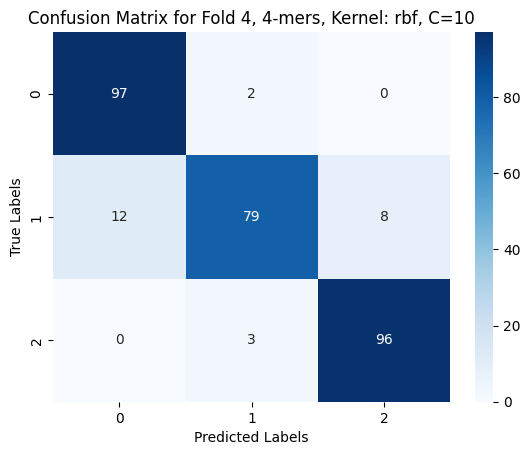


Results for Fold 5, 4-mers, Kernel: rbf, C=10
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        99
           1       0.90      0.83      0.86        99
           2       0.92      0.96      0.94        99

    accuracy                           0.91       297
   macro avg       0.91      0.91      0.91       297
weighted avg       0.91      0.91      0.91       297

Confusion Matrix:
[[94  5  0]
 [ 9 82  8]
 [ 0  4 95]]


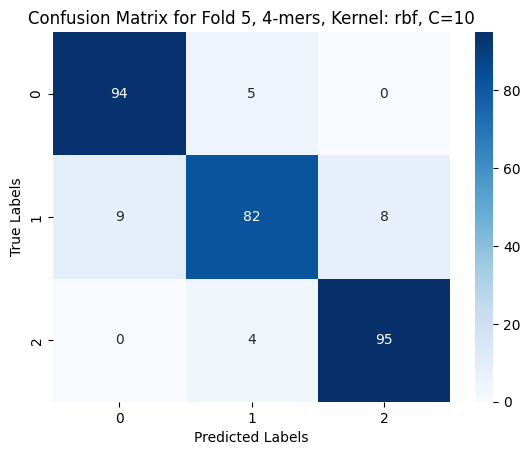


Results for Fold 6, 4-mers, Kernel: rbf, C=10
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        99
           1       0.98      0.85      0.91        99
           2       0.97      0.98      0.97        99

    accuracy                           0.94       297
   macro avg       0.95      0.94      0.94       297
weighted avg       0.95      0.94      0.94       297

Confusion Matrix:
[[99  0  0]
 [12 84  3]
 [ 0  2 97]]


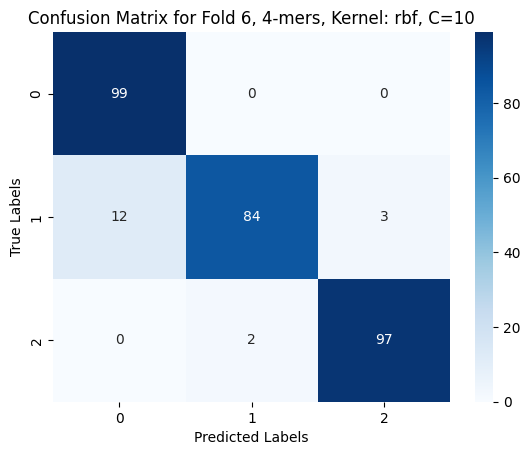


Results for Fold 7, 4-mers, Kernel: rbf, C=10
Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        99
           1       0.97      0.90      0.93        99
           2       0.97      0.99      0.98        99

    accuracy                           0.96       297
   macro avg       0.96      0.96      0.96       297
weighted avg       0.96      0.96      0.96       297

Confusion Matrix:
[[97  2  0]
 [ 7 89  3]
 [ 0  1 98]]


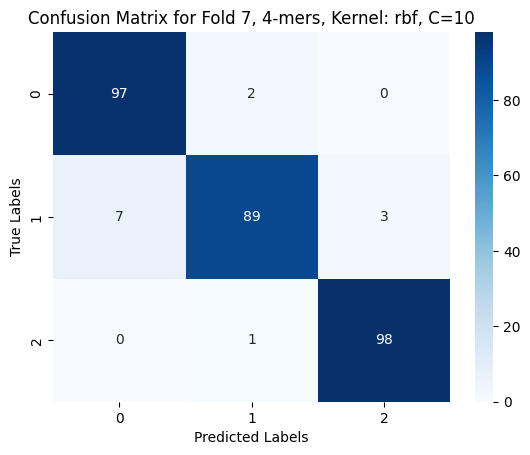


Results for Fold 8, 4-mers, Kernel: rbf, C=10
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        99
           1       0.95      0.88      0.91        99
           2       0.96      0.95      0.95        98

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296

Confusion Matrix:
[[98  1  0]
 [ 8 87  4]
 [ 1  4 93]]


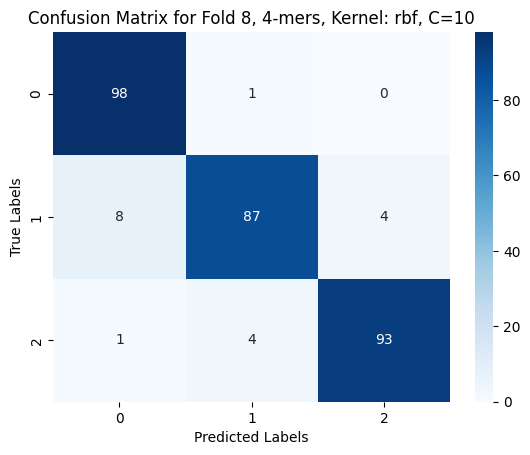


Results for Fold 9, 4-mers, Kernel: rbf, C=10
Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        98
           1       0.97      0.87      0.91        99
           2       0.98      0.97      0.97        99

    accuracy                           0.95       296
   macro avg       0.95      0.95      0.95       296
weighted avg       0.95      0.95      0.95       296

Confusion Matrix:
[[98  0  0]
 [11 86  2]
 [ 0  3 96]]


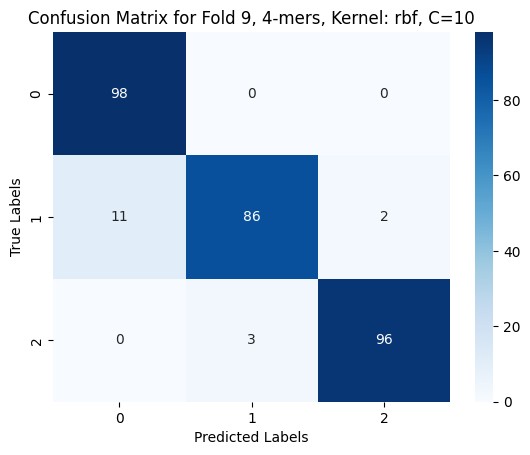


Results for Fold 10, 4-mers, Kernel: rbf, C=10
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        99
           1       0.95      0.88      0.91        98
           2       0.97      0.97      0.97        99

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296

Confusion Matrix:
[[97  2  0]
 [ 9 86  3]
 [ 0  3 96]]


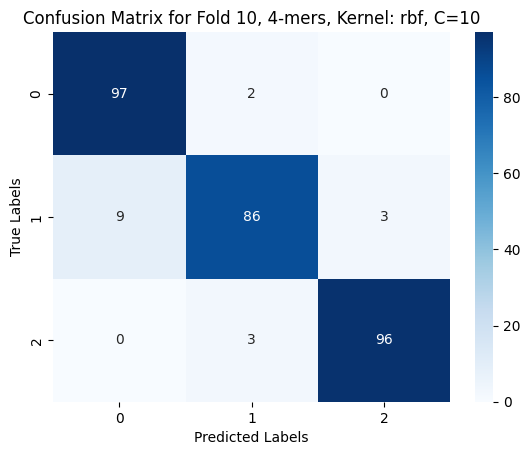


Average Accuracy over 10 folds: 0.94


In [36]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# ====================================
# Helper function to create k-mers
def kmers(seq, size):
    return [seq[x:x + size].lower() for x in range(len(seq) - size + 1)]

# ====================================
# Function to preprocess and train SVM with 10-fold cross-validation
def process_and_train_svm_kfold(data, k=4, kernel='rbf', C=10):
    # Split into k-mers
    data[f'{k}mers'] = data.apply(lambda x: kmers(x['sequence'], size=k), axis=1)

    # Prepare X and y
    X = list(data[f'{k}mers'])
    X = [(' '.join(X[seq])) for seq in range(len(X))]
    y = data['class'].copy()

    # Tokenize
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)
    X_tokenized = tokenizer.texts_to_sequences(X)
    max_dna = max([len(s.split()) for s in X])
    X_padded = pad_sequences(X_tokenized, maxlen=max_dna, padding='post')

    # Encode labels
    label_encoder = LabelEncoder()
    labels = np.array(y)
    labels = label_encoder.fit_transform(labels)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_os, y_os = smote.fit_resample(X_padded, labels)

    # Initialize 10-fold cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold = 1
    accuracies = []

    for train_index, test_index in skf.split(X_os, y_os):
        X_train, X_test = X_os[train_index], X_os[test_index]
        y_train, y_test = y_os[train_index], y_os[test_index]

        # Train SVM with specified kernel and C
        svm = SVC(kernel=kernel, C=C)
        svm.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = svm.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        # Print results for each fold
        print(f"\nResults for Fold {fold}, {k}-mers, Kernel: {kernel}, C={C}")
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Classification Report:\n{report}')
        print(f'Confusion Matrix:\n{cm}')
        
        # Plot confusion matrix for each fold
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for Fold {fold}, {k}-mers, Kernel: {kernel}, C={C}')
        plt.show()

        accuracies.append(accuracy)
        fold += 1

    # Print overall accuracy
    print(f"\nAverage Accuracy over 10 folds: {np.mean(accuracies):.2f}")

# Run the SVM training with 10-fold validation for 4-mers with rbf kernel and C=10
process_and_train_svm_kfold(data, k=4, kernel='rbf', C=10)
